# Design and Architecture of a Scalable Event Booking System

In this document, we will discuss the design of the Book My Show events system, focusing on both its functional and non-functional requirements. We will also delve into various concepts related to system design like CAP theorem, locking mechanisms, and API strategies while providing detailed explanations, code examples, diagrams, and flowcharts.

---

### Images

Below are the images converted to base64 format.

1. **Event View Screenshot**

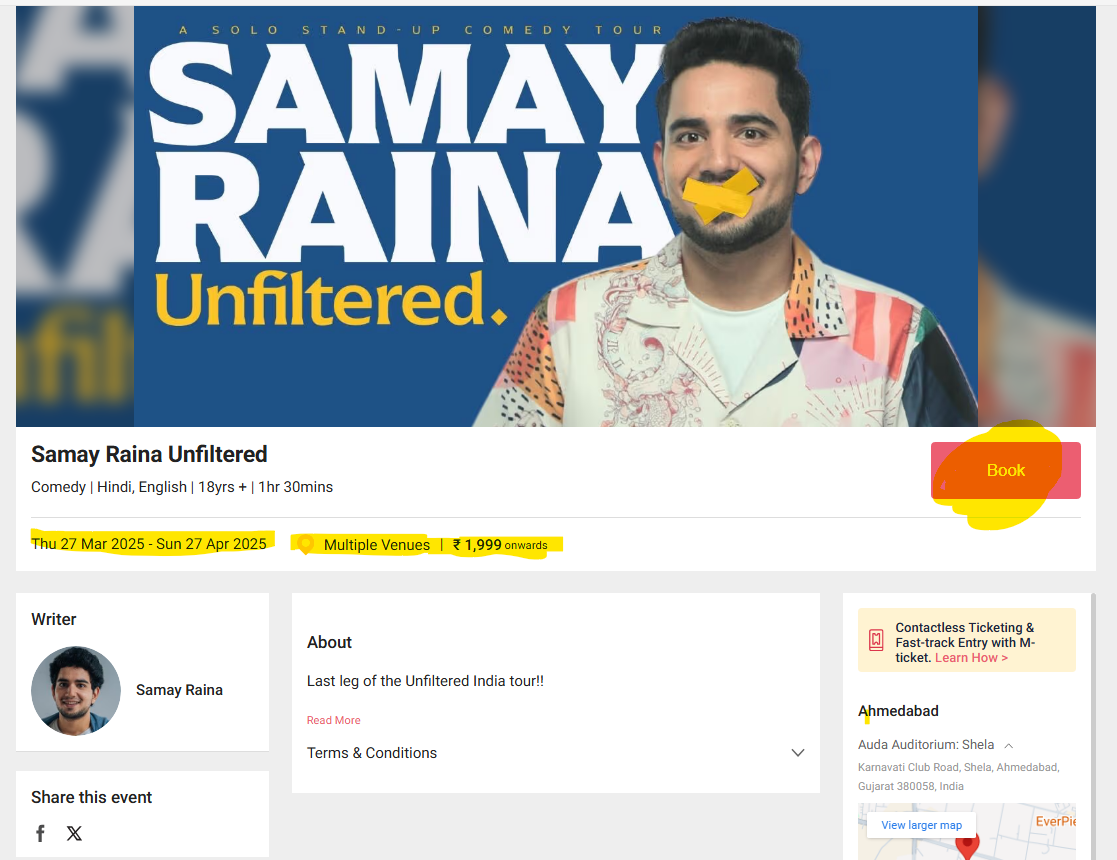

2. **Booking Screenshot**

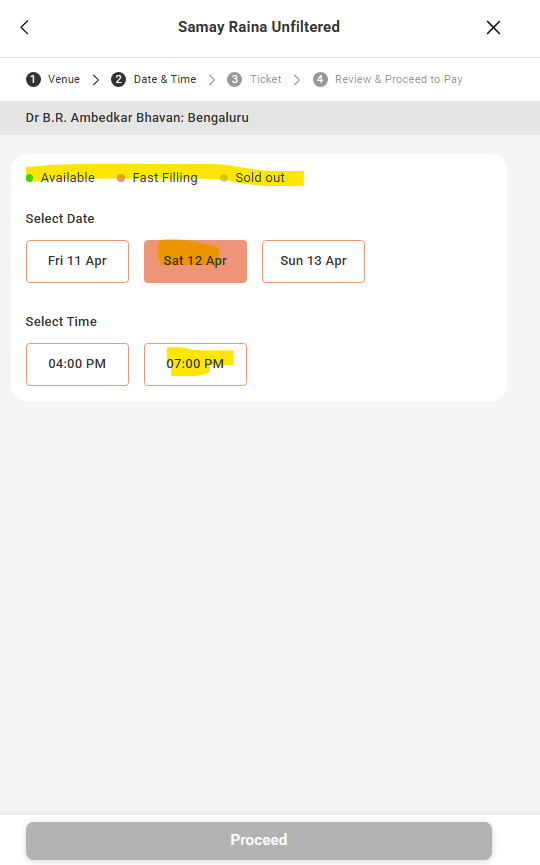

3. **Search Event Screenshot**

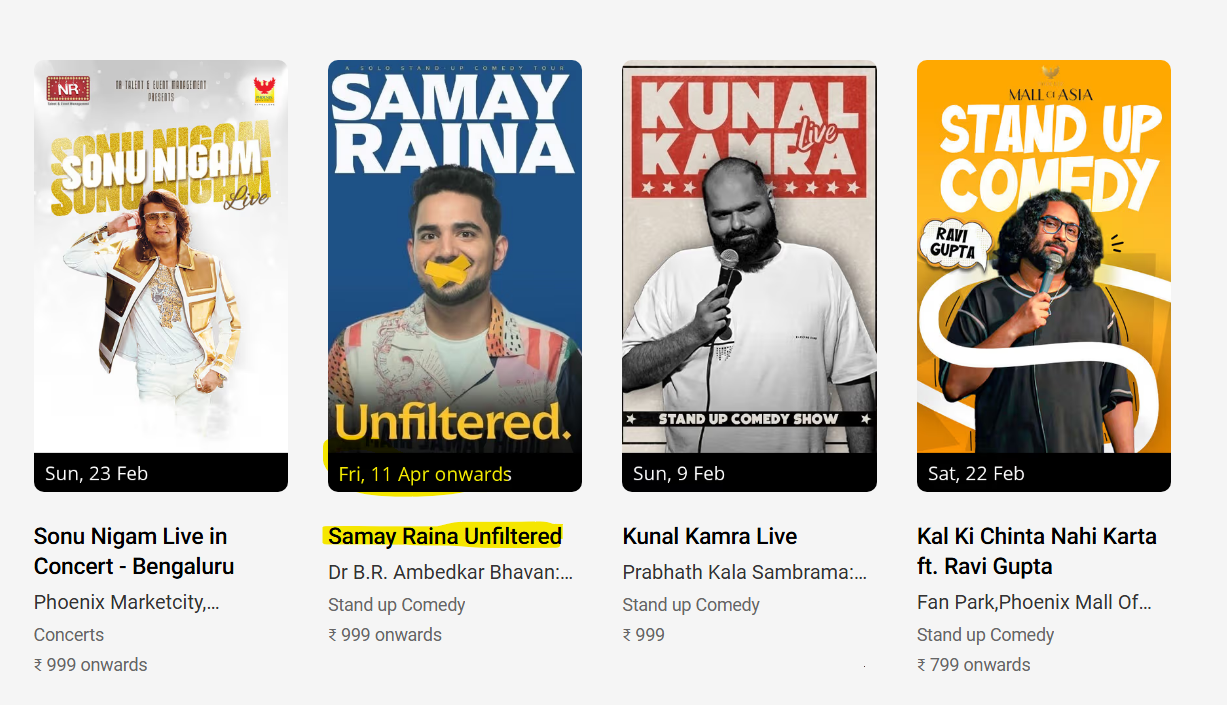

---

## Functional Requirements

1. **User should be able to view events** (Event Screenshot)

2. **Book a ticket for an event** (Booking screenshot)

3. **Search for any event** (Search Event Screenshot)

**Out of Scope Requirements** (for clarity in discussions):
1. User registration
2. View my orders
3. Admin adding an event
4. Dynamic pricing

### Flowchart for Functional Requirements

```mermaid
flowchart LR
    A[User]
    A --> B[View Events]
    A --> C[Book Tickets]
    A --> D[Search Events]

    B --> E[Display Event List]
    C --> F[Choose Event and Seat]
    C --> G[Confirm Payment]
    D --> H[Input Search Criteria]
    D --> I[Display Search Results]
```

---

## Non-Functional Requirements

1. **Scalability**: Handle high throughput demands, especially during popular events (e.g., World Cup).
2. **Low Latency**: Ensure response times are less than 500ms.
3. **Read Heavy**: The system should be optimized to handle read operations efficiently, in a 100:1 ratio (reads to writes).
4. **High Availability**: The system should be always accessible to users.

### Expanded Overview of Non-Functional Requirements

| Requirement      | Description                                                        | Example                                                                                   |
|------------------|--------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| Scalability      | Ability to handle increased loads during peak times                | Adding more servers or instances during major events like the World Cup.                |
| Low Latency      | Response times should be under 500 ms                              | Using caching mechanisms (like Redis) to serve frequent requests quickly.                |
| Read Heavy       | System optimized for read operations (100:1 ratio of reads to writes) | Implementing read replicas in the database to manage high volumes of read requests.     |
| High Availability| The system must remain up and running at all times                 | Utilizing load balancing and failover strategies to ensure uptime.                       |

### Flowchart for Non-Functional Requirements

```mermaid
flowchart TD
    A[User Access] --> B[Incoming Requests]
    B --> C[Load Balancer]
    C --> D[Service Instances]
    
    D --> E[Redis Cache]
    D --> F[Database]
    
    E --> G[Event Data]
    F --> H[Read Operations]
```

---

## CAP Theorem

### What is CAP Theorem?

CAP theorem, proposed by Eric Brewer, states that in a distributed data store, it is impossible to simultaneously guarantee all three of the following properties:

1. **Consistency**: All nodes see the same data at the same time. 
2. **Availability**: Every request receives a response, either with the requested data or an error.
3. **Partition Tolerance**: The system continues to operate despite arbitrary partitioning due to network failures.

### Examples

- **Consistency**: In a social media application like Twitter, if User A tweets, the tweet should be instantly visible to all users without discrepancies.
  
- **Availability**: A service like YouTube should be accessible to users, even under heavy loads, ensuring users can watch videos without interruptions.

### Trade-offs

In practice, systems often need to prioritize either consistency or availability depending on use cases.

---

## Consistency vs. Availability in Book My Show

- **View and Search Events**: **Prioritize availability** to ensure that users can always access event information.
  
- **During Ticket Booking**: **Prioritize consistency** to prevent double bookings.

### What if Two Users Book at the Same Time?

Implementing a **locking mechanism** ensures that inconsistency does not occur.

### Locking Mechanisms:

1. **Optimistic Locking**: Allows concurrency and checks for updates upon commit.
2. **Pessimistic Locking**: Locks the resource immediately upon selection, preventing simultaneous access.
3. **Distributed Locking**: Involves a central coordination service (like Zookeeper) for synchronizing across nodes.

---

## Trade-Off in CAP Theorem in Practice

In ML systems, preserving data consistency while ensuring system availability is critical. For example, an online recommendation system could employ:

- **Optimistic Approach**: Allow multiple users to receive recommendations but reconcile data for correctness later.
- **Pessimistic Approach**: Lock data entries during processing, ensuring accuracy.

---

## Core Entities in the Book My Show Case Study

| Entity         | Description                                      | Attributes                                   |
|----------------|--------------------------------------------------|----------------------------------------------|
| Events         | Information about events available for booking. | id, name, description, date, venue_id      |
| Users          | Customer data, preferences, and bookings.       | id, name, email, preferences                |
| Venues         | Locations hosting the events.                    | id, name, location, capacity                |
| Performers     | Artists or teams performing at events.           | id, name, bio, photo                        |
| Tickets        | Individual tickets linked with events.           | id, event_id, seat_number, price            |
| Bookings       | Record of user bookings and ticket allocation.   | id, user_id, ticket_id, status, timestamp   |

---

## API Strategy

### View Event API

**GET request for events/event_id:**

- **Input**: 
  - event_id
- **Output**: 
  - event details including venue, performer, ticket list, and pricing.

### Search Event API

**GET request for search events:**

- **Input**: 
  - keyword, startDate, endDate, pageSize, pageNumber.
- **Output**: 
  - List of events based on filters.

#### Pagination Concept in Detail

Pagination is an important design strategy that helps manage large datasets. Here’s a Python snippet illustrating pagination:

```python
def paginate_results(data, page_number, page_size):
    start = (page_number - 1) * page_size
    end = start + page_size
    return data[start:end]
```

### Book Tickets API

**POST request to book tickets:**

- **Input**: 
  - event_id, ticket_id, payment details.
- **Output**: 
  - confirmation order status.

---

### High-Level Design Explanation

In a high-level design, we divide the system's architecture into clear components—APIs and databases.

- **API Gateway**: Manages user requests and directs them to appropriate microservices, handling aspects like authentication and rate limiting.
- **Service Instances**: Include various microservices for displaying events, searching for events, and booking tickets.
- **Databases**: Store core tables related to entities such as Events, Users, etc.

### Flowchart of High-Level Design

```mermaid
flowchart TD
    A[Client] -->|Request| B[API Gateway]
    
    subgraph Secure Access
        C[Authentication]
        D[Rate Limiting]
    end

    B --> C
    B --> D

    subgraph Services
        E[View Event Service]
        F[Search Service]
        G[Booking Service]
        H[Payment Processing - Stripe]
    end

    B --> E
    B --> F
    B --> G

    E -.->|Cache| I[Redis]
    F -.->|Search| J[ElasticSearch]

    G --> K[Database]
    G ---> H
    
    K --> L[Event]
    K --> M[User]
    K --> N[Ticket]
    K --> O[Booking]
```

---

## Why API Gateway Can't Go Directly to the Database?

The API Gateway acts as a mediator and offers several advantages, including:
- **Security**: Centralizes authentication and authorization processes.
- **Load Balancing**: Distributes requests evenly to prevent bottlenecks.
- **Rate Limiting**: Controls request frequency to safeguard against overload.
- **Microservices Coordination**: Simplifies interaction between multiple microservices.

---

### Booking Feature and Stripe Payment

1. **Booking Service**: Collects necessary information including user and ticket details.
2. **Integrated Payment Gateway**: E.g., Stripe allows handling payment processing while ensuring security.

**Stripe Webhook**: Allows your application to listen for events triggered by Stripe payments, enabling real-time processing of payment confirmations.

---

## UML Design Approach

The UML (Unified Modeling Language) design approach is crucial for visualizing and documenting the design of software systems. Here are the key features:

- **Standardization**: Offers a standardized way to represent systems.
- **Visualization**: Enables clear and direct modeling of the components and structure.
- **Abstraction**: Helps simplify complex systems.

### Key UML Diagram Categories

1. **Structural Diagrams** (e.g., Class Diagram, Object Diagram)
2. **Behavioral Diagrams** (e.g., Use Case Diagram, Sequence Diagram)

#### Example:

When designing a Library Management System:

- Use case for **checking out a book**.
- Class diagram representing **Books**, **Users**, and **Loans** interacting with each other.

---

## Locking Mechanism in Ticket Booking Design

The locking mechanism is crucial to ensuring data integrity during concurrent transactions in a ticket booking system.

### Types of Locking Mechanisms:

| Type                | Description                                        | Example                                    |
|---------------------|----------------------------------------------------|--------------------------------------------|
| Optimistic Locking   | Assumes conflicts are rare and checks before commit| User updates a ticket and checks the status before finalizing|
| Pessimistic Locking  | Locks resources immediately to prevent access      | Seat is locked once a user selects it       |
| Distributed Locking  | Manages locks across distributed systems           | Uses a service like Zookeeper for coordination |

### Example of Locking Mechanism Flow:

- User A selects a seat and initiates booking.
- The system locks the seat until the transaction is complete or times out.
- User B attempting to book the same seat will receive an error message until User A either finalizes or cancels the booking.

### ACID Properties Relevant to Locking Mechanism

The ACID properties are critical for maintaining database integrity during transactions:

- **Atomicity**: Ensures all steps are completed or none are applied.
- **Consistency**: The database remains in a valid state post-transaction.
- **Isolation**: Transactions do not interfere with each other.
- **Durability**: Once committed, transactions withstand failures.

---

## Handling Scalability Issues

### Addressing Scalability in Design:

1. **Horizontal Scaling**: Adding more instances can manage increased loads effectively.
2. **Load Balancers**: Distribute incoming requests intelligently to prevent overloading any single server.

### Example Implementation:

- Utilize **Load Balancing** on incoming API requests to ensure smooth operations.
- Deploy **Read Replicas** to handle high volumes of read requests efficiently.

---

## In-depth on Elasticsearch

### What is Elasticsearch?

- A **distributed, open-source search and analytics engine** capable of handling and processing massive amounts of both structured and unstructured data in real-time.

### Key Features:
- **Full-text Search** capabilities for complex queries.
- **Schema-free JSON** data handling allows for dynamic data models.
- **Powerful Query DSL** for building complex queries and analytics.

### Common Use Cases:

1. **Search Applications**: Building search functionality in e-commerce sites.
2. **Log Data Analysis**: Monitoring and analyzing logs from servers or applications.

### Example Implementation with Elasticsearch:

An index can store event data allowing for fast search and retrieval based on user input.

---

## Difference between CDC and Cron Jobs

| Aspect           | Change Data Capture (CDC)                                     | Cron Jobs                                                       |
|------------------|---------------------------------------------------------------|---------------------------------------------------------------|
| Purpose           | Captures real-time changes in databases                       | Automates scheduled tasks                                      |
| Trigger Mechanism | Event-driven changes                                           | Time-driven schedules                                           |
| Frequency         | Near real-time updates                                         | Fixed interval schedules                                        |
| Use Cases         | Data replication and event-driven systems                     | Regular reports and data backups                               |
| Example           | Updates are captured immediately in data storage              | A cron job runs nightly to back up the database                |

### Summary

This case study encapsulates crucial architectural decisions and the strategies necessary to build a robust system like Book My Show. We explored various components, from functional requirements to non-functional considerations like scalability and latency. Utilizing tools like Elasticsearch and Redis can dramatically improve usability and efficiency while managing the trade-offs between consistency and availability in a high-stakes environment.

---

### Final Flowchart Integrating All Components

```mermaid
flowchart TD
    A[Client] -->|Request| B[API Gateway]
    
    subgraph Secure Access
        C[Authentication]
        D[Rate Limiting]
    end

    B --> C
    B --> D

    subgraph Services
        E[View Event Service]
        F[Search Service]
        G[Booking Service]
        H[Payment Processing - Stripe]
    end

    B --> E
    B --> F
    B --> G

    E -.->|Cache| I[Redis]
    F -.->|Search| J[ElasticSearch]

    G --> K[Database]
    G ---> H
    
    K --> L[Event]
    K --> M[User]
    K --> N[Ticket]
    K --> O[Booking]
```



---


Certainly! Below are some code examples that you can incorporate into the **"Design and Architecture of a Scalable Event Booking System"** notes to demonstrate various concepts and functionality discussed.

---

### 1. **Pagination in Search Results** (Python)

Pagination is crucial for efficiently managing large datasets in search functionalities. Below is an example Python code snippet to implement pagination.

```python
def paginate_results(data, page_number, page_size):
    """
    Function to paginate data for search results.

    :param data: List of events or any data
    :param page_number: The current page number (1-based index)
    :param page_size: Number of items per page
    :return: A slice of the data for the requested page
    """
    start = (page_number - 1) * page_size
    end = start + page_size
    return data[start:end]

# Example usage
events = [
    {"id": 1, "name": "Concert A", "date": "2025-02-15"},
    {"id": 2, "name": "Concert B", "date": "2025-02-16"},
    {"id": 3, "name": "Concert C", "date": "2025-02-17"},
    {"id": 4, "name": "Concert D", "date": "2025-02-18"},
    {"id": 5, "name": "Concert E", "date": "2025-02-19"}
]

page_number = 1
page_size = 2
paginated_results = paginate_results(events, page_number, page_size)
print(paginated_results)
```

---

### 2. **Event Search Functionality with Elasticsearch Query (Python)**

Elasticsearch can be used to provide fast search capabilities. Here’s an example of how a basic query could be made using Elasticsearch's Python client.

```python
from elasticsearch import Elasticsearch

# Initialize Elasticsearch client
es = Elasticsearch()

# Example: Searching for events based on a keyword
def search_events(keyword, start_date=None, end_date=None):
    query = {
        "query": {
            "bool": {
                "must": [
                    {"match": {"name": keyword}},
                    {"range": {"date": {"gte": start_date, "lte": end_date}}} if start_date and end_date else {}
                ]
            }
        }
    }
    
    # Search query execution
    response = es.search(index="events", body=query)
    
    return response['hits']['hits']

# Example usage
events = search_events("Concert", start_date="2025-02-01", end_date="2025-02-28")
for event in events:
    print(event["_source"])
```

---

### 3. **Optimistic Locking Example (Python)**

Optimistic locking can be used to manage concurrency in booking systems. Below is an example in Python, simulating an optimistic locking mechanism.

```python
import random
import time

class TicketBookingSystem:
    def __init__(self):
        # Simulate an event with available tickets
        self.event = {"id": 1, "tickets_available": 10, "version": 1}

    def book_ticket(self, user_id):
        # Simulate optimistic locking by checking the version
        current_version = self.event['version']
        print(f"User {user_id} attempting to book a ticket...")

        if self.event['tickets_available'] > 0:
            # Simulating a delay in booking process
            time.sleep(random.uniform(0.1, 0.5))

            # Check if the version has changed (conflict)
            if current_version == self.event['version']:
                # Proceed to book the ticket
                self.event['tickets_available'] -= 1
                self.event['version'] += 1
                print(f"User {user_id} successfully booked a ticket!")
            else:
                print(f"User {user_id} failed to book a ticket due to a conflict!")
        else:
            print("No tickets available.")

# Example usage
system = TicketBookingSystem()

# Simulating two users attempting to book a ticket at the same time
import threading

def user_booking(user_id):
    system.book_ticket(user_id)

threads = []
for i in range(1, 3):
    t = threading.Thread(target=user_booking, args=(i,))
    threads.append(t)
    t.start()

for t in threads:
    t.join()
```

---

### 4. **Pessimistic Locking Example (Python with Redis)**

In a ticket booking system, pessimistic locking prevents concurrent access to a resource. Here's an example using Redis for locking.

```python
import redis
import time

class TicketBookingSystemWithLock:
    def __init__(self):
        self.redis_client = redis.StrictRedis(host='localhost', port=6379, db=0)
        self.event_id = "event_1"
        self.ticket_lock_key = f"{self.event_id}_lock"

    def book_ticket(self, user_id):
        print(f"User {user_id} attempting to book a ticket...")

        # Try to acquire the lock
        lock_acquired = self.redis_client.setnx(self.ticket_lock_key, "locked")
        
        if lock_acquired:
            try:
                # Lock acquired, proceed with booking
                if self.redis_client.get(self.event_id).decode("utf-8") == "available":
                    print(f"User {user_id} successfully booked a ticket!")
                    self.redis_client.set(self.event_id, "booked")
                else:
                    print("No tickets available.")
            finally:
                # Release the lock after the operation
                self.redis_client.delete(self.ticket_lock_key)
        else:
            print(f"User {user_id} failed to book a ticket, seat is locked.")

# Example usage
system_with_lock = TicketBookingSystemWithLock()

# Simulating multiple users attempting to book a ticket concurrently
import threading

def user_booking_with_lock(user_id):
    system_with_lock.book_ticket(user_id)

threads = []
for i in range(1, 3):
    t = threading.Thread(target=user_booking_with_lock, args=(i,))
    threads.append(t)
    t.start()

for t in threads:
    t.join()
```

---

### 5. **Booking API Example (Flask)**

Here’s an example of how the **Book Tickets API** can be implemented using Flask.

```python
from flask import Flask, request, jsonify

app = Flask(__name__)

# Simulating an event database
events = {
    1: {"name": "Concert A", "tickets_available": 100},
    2: {"name": "Concert B", "tickets_available": 50}
}

@app.route('/events/<int:event_id>', methods=['GET'])
def get_event(event_id):
    event = events.get(event_id)
    if event:
        return jsonify(event), 200
    else:
        return jsonify({"error": "Event not found"}), 404

@app.route('/book_ticket', methods=['POST'])
def book_ticket():
    data = request.get_json()
    event_id = data.get('event_id')
    ticket_count = data.get('ticket_count')

    event = events.get(event_id)
    if event:
        if event["tickets_available"] >= ticket_count:
            event["tickets_available"] -= ticket_count
            return jsonify({"status": "Booking confirmed", "remaining_tickets": event["tickets_available"]}), 200
        else:
            return jsonify({"error": "Not enough tickets available"}), 400
    else:
        return jsonify({"error": "Event not found"}), 404

if __name__ == '__main__':
    app.run(debug=True)
```

---

### 6. **Stripe Payment Integration (Python)**

Below is a simple example of integrating Stripe for payment processing.

```python
import stripe

stripe.api_key = "your_stripe_api_key"

def create_payment_intent(amount, currency="usd"):
    payment_intent = stripe.PaymentIntent.create(
        amount=amount,
        currency=currency,
        payment_method_types=["card"],
    )
    return payment_intent.client_secret

# Example usage: Create a payment intent for $20
amount_in_cents = 2000  # $20 in cents
client_secret = create_payment_intent(amount_in_cents)
print("Client Secret for Stripe:", client_secret)
```

---

These code snippets provide a foundation for demonstrating various parts of the event booking system. You can modify and extend them based on the specific requirements or scenarios discussed in your notes.

---
## Conclusion

This comprehensive overview outlines the architecture and design elements necessary to create a robust, scalable, and efficient event management system like Book My Show, prioritizing user experience and system reliability.

---